In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))
        #new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls,  epoch, a=1, b=0.5, c=0.02): #modified
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b #modified

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss #modified
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [12]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=12)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


6673868

In [11]:
import gc

def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    #epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        #if (epoch + 1) % 10 == 0:
        #    epoch_weight = # modified


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:
            gc.collect()
            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], epoch=epoch)
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()

            gc.collect()
        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        if epoch % 5 == 0:
            print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [28]:
import gc
del up_changer
del down_changer

gc.collect()
torch.cuda.empty_cache()



up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None)


100%|██████████| 11/11 [00:24<00:00,  2.21s/it]


ep 0: down loss = 0.19958508962934668, up loss = 0.1444329030134461, reconst.loss = 0.2873575728047978, down adj mae = 0.2550216723572124, up adj mae = 0.29841550371863623


100%|██████████| 11/11 [00:22<00:00,  2.03s/it]


ep 1: down loss = 0.17630724202502857, up loss = 0.11211663416840813, reconst.loss = 0.24656351994384418, down adj mae = 0.23042452064427463, up adj mae = 0.2583832469853488


100%|██████████| 11/11 [00:22<00:00,  2.00s/it]


ep 2: down loss = 0.16545250740918246, up loss = 0.0943763865665956, reconst.loss = 0.2195943295955658, down adj mae = 0.22246170043945312, up adj mae = 0.23123186826705933


100%|██████████| 11/11 [00:21<00:00,  2.00s/it]


ep 3: down loss = 0.15273935415528037, up loss = 0.07914493368430571, reconst.loss = 0.19602766091173346, down adj mae = 0.212913686578924, up adj mae = 0.20267604020508853


100%|██████████| 11/11 [00:21<00:00,  1.95s/it]


ep 4: down loss = 0.1457446190443906, up loss = 0.06983761218461124, reconst.loss = 0.1790506677194075, down adj mae = 0.19895157082514328, up adj mae = 0.18420512703332034


100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


ep 5: down loss = 0.13923707604408264, up loss = 0.06405107846314256, reconst.loss = 0.17186274040829053, down adj mae = 0.19163602590560913, up adj mae = 0.17092024060812863


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


ep 6: down loss = 0.13149936361746353, up loss = 0.06168524717742747, reconst.loss = 0.16474448415366086, down adj mae = 0.19007838449694894, up adj mae = 0.16779828748919748


100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


ep 7: down loss = 0.1271307956088673, up loss = 0.06026267903772267, reconst.loss = 0.16490484096787192, down adj mae = 0.1728405085476962, up adj mae = 0.15855771032246677


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


ep 8: down loss = 0.11846224895932457, up loss = 0.0578379211100665, reconst.loss = 0.1589286137710918, down adj mae = 0.16433664749969135, up adj mae = 0.156422113830393


100%|██████████| 11/11 [00:20<00:00,  1.84s/it]


ep 9: down loss = 0.10548177564685995, up loss = 0.05242473428899592, reconst.loss = 0.15431655672463504, down adj mae = 0.16350140354850076, up adj mae = 0.14935076236724854


100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


ep 10: down loss = 0.09665599126707423, up loss = 0.05044945126230067, reconst.loss = 0.1520677168260921, down adj mae = 0.15985486859625037, up adj mae = 0.14975644648075104


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


ep 11: down loss = 0.08720507743683728, up loss = 0.04917994954369285, reconst.loss = 0.15172205458987842, down adj mae = 0.16220905834978278, up adj mae = 0.15039472011002628


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


ep 12: down loss = 0.0810599997639656, up loss = 0.048419706523418427, reconst.loss = 0.14917458322915164, down adj mae = 0.1573813720182939, up adj mae = 0.1506378244269978


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


ep 13: down loss = 0.0747999068010937, up loss = 0.045236782932823356, reconst.loss = 0.14853505383838306, down adj mae = 0.1494771824641661, up adj mae = 0.1432246376167644


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


ep 14: down loss = 0.07128007032654503, up loss = 0.04541273990815336, reconst.loss = 0.1471002237363295, down adj mae = 0.15213853256268936, up adj mae = 0.14462279189716687


100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


ep 15: down loss = 0.06882819126952779, up loss = 0.043599825013767586, reconst.loss = 0.1451692987572063, down adj mae = 0.15868526832623917, up adj mae = 0.14294241097840396


100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


ep 16: down loss = 0.058424523269588295, up loss = 0.04120536182414402, reconst.loss = 0.14418774978681045, down adj mae = 0.1495481770146977, up adj mae = 0.1440413838083094


100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


ep 17: down loss = 0.053937025368213654, up loss = 0.041700302199883896, reconst.loss = 0.14287075129422275, down adj mae = 0.14592537690292706, up adj mae = 0.14660536023703488


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


ep 18: down loss = 0.050151440907608376, up loss = 0.03858486461368474, reconst.loss = 0.14309704574671658, down adj mae = 0.15001278573816473, up adj mae = 0.14268351143056696


100%|██████████| 11/11 [00:19<00:00,  1.77s/it]


ep 19: down loss = 0.04403211785988374, up loss = 0.03671772913499312, reconst.loss = 0.14195580915971237, down adj mae = 0.14631915498863568, up adj mae = 0.14063409783623435


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 20: down loss = 0.041129063814878464, up loss = 0.03592307391491803, reconst.loss = 0.14166605337099594, down adj mae = 0.1460809368978847, up adj mae = 0.1395243609493429


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 21: down loss = 0.0377562049437653, up loss = 0.03461778163909912, reconst.loss = 0.14033169502561743, down adj mae = 0.14582998373291708, up adj mae = 0.14027230983430689


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 22: down loss = 0.035323194482109764, up loss = 0.033452717079357666, reconst.loss = 0.140074070204388, down adj mae = 0.14315500042655252, up adj mae = 0.1398703557523814


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


ep 23: down loss = 0.03590215132995085, up loss = 0.03550464524464174, reconst.loss = 0.14143892445347525, down adj mae = 0.14121476764028723, up adj mae = 0.14005454968322406


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 24: down loss = 0.03245482830838724, up loss = 0.03307791257446462, reconst.loss = 0.13994736834005875, down adj mae = 0.14304123683409256, up adj mae = 0.13764771954579788


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


ep 25: down loss = 0.031251768666234886, up loss = 0.032237525352022865, reconst.loss = 0.13970169695940884, down adj mae = 0.1416047608310526, up adj mae = 0.13798353211446243


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


ep 26: down loss = 0.02788134664297104, up loss = 0.031460190869190476, reconst.loss = 0.1384956200014461, down adj mae = 0.13700903139331125, up adj mae = 0.13680558583953165


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 27: down loss = 0.025515694679184395, up loss = 0.030474170873110943, reconst.loss = 0.13865780559453098, down adj mae = 0.13847754760222, up adj mae = 0.1375182650306008


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 28: down loss = 0.023788339881734413, up loss = 0.03002386303110556, reconst.loss = 0.137612215497277, down adj mae = 0.1407063901424408, up adj mae = 0.13750491155819458


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 29: down loss = 0.023291142318736423, up loss = 0.031249136917970398, reconst.loss = 0.13777280260216107, down adj mae = 0.13781531696969812, up adj mae = 0.1402121822942387


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 30: down loss = 0.021763548932292244, up loss = 0.0287456348199736, reconst.loss = 0.13721214776689356, down adj mae = 0.13846195963296024, up adj mae = 0.134357174011794


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 31: down loss = 0.020355066453868694, up loss = 0.028144349936734547, reconst.loss = 0.13800353895534168, down adj mae = 0.13853745636614886, up adj mae = 0.1368074898015369


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 32: down loss = 0.019811202009970493, up loss = 0.029144043949517338, reconst.loss = 0.13943766734816812, down adj mae = 0.1345340203155171, up adj mae = 0.13467588817531412


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 33: down loss = 0.01868289861489426, up loss = 0.027809079228477043, reconst.loss = 0.13762959973378616, down adj mae = 0.13601898063312878, up adj mae = 0.13464319299567828


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 34: down loss = 0.017640001394531944, up loss = 0.02699771811338988, reconst.loss = 0.13670248335058038, down adj mae = 0.1359908411448652, up adj mae = 0.1361357576467774


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 35: down loss = 0.016544193198735065, up loss = 0.02689096483994614, reconst.loss = 0.13639817048202862, down adj mae = 0.135228769345717, up adj mae = 0.13545651124282318


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 36: down loss = 0.0163030657409267, up loss = 0.0262191178785129, reconst.loss = 0.13658363575285132, down adj mae = 0.136893092231317, up adj mae = 0.13381167568943717


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 37: down loss = 0.015402616001665592, up loss = 0.02555289627476172, reconst.loss = 0.13551134954799304, down adj mae = 0.13788764043287796, up adj mae = 0.13617435639554804


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 38: down loss = 0.014841617593033747, up loss = 0.025939817963676018, reconst.loss = 0.13670212572271173, down adj mae = 0.13855198432098736, up adj mae = 0.13720822740684857


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 39: down loss = 0.01399335807020014, up loss = 0.025168206881393086, reconst.loss = 0.13598105853254144, down adj mae = 0.13662379844622177, up adj mae = 0.13381072607907382


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 40: down loss = 0.013516221110793676, up loss = 0.024727446111765774, reconst.loss = 0.1350214102051475, down adj mae = 0.1353769234635613, up adj mae = 0.1344282180070877


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 41: down loss = 0.012979561039669947, up loss = 0.024371796202930538, reconst.loss = 0.13488126342946832, down adj mae = 0.13781954212622208, up adj mae = 0.13531517847017807


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 42: down loss = 0.012844024564732204, up loss = 0.024629830636761406, reconst.loss = 0.1364949724890969, down adj mae = 0.1369420967318795, up adj mae = 0.1367672092535279


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 43: down loss = 0.012241166085004807, up loss = 0.024467126720330933, reconst.loss = 0.13634124262766403, down adj mae = 0.13891670920632102, up adj mae = 0.13611150329763239


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 44: down loss = 0.012736159884794191, up loss = 0.024092521518468857, reconst.loss = 0.13574736226688733, down adj mae = 0.1425051675601439, up adj mae = 0.13586188446391712


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 45: down loss = 0.01267293518917127, up loss = 0.023562794043259186, reconst.loss = 0.13486077839677985, down adj mae = 0.14216914637522263, up adj mae = 0.13495285944505173


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 46: down loss = 0.011370278471572832, up loss = 0.023131693798032673, reconst.loss = 0.13394657319242304, down adj mae = 0.13555566560138355, up adj mae = 0.13200263408097354


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 47: down loss = 0.01077983994036913, up loss = 0.02292442541908134, reconst.loss = 0.13412663611498746, down adj mae = 0.13683462007479233, up adj mae = 0.13337583298032935


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 48: down loss = 0.010483444753018293, up loss = 0.022981197488578884, reconst.loss = 0.13471778820861469, down adj mae = 0.13768492909994992, up adj mae = 0.13446210324764252


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 49: down loss = 0.010296958075328306, up loss = 0.02298876033587889, reconst.loss = 0.13457315076481213, down adj mae = 0.13609821688045154, up adj mae = 0.1339914080771533


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 50: down loss = 0.010026326741684567, up loss = 0.022937346757812935, reconst.loss = 0.13506665419448505, down adj mae = 0.13624145903370596, up adj mae = 0.13458238677545029


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 51: down loss = 0.009495282037691637, up loss = 0.022317519580776043, reconst.loss = 0.1342286155982451, down adj mae = 0.13433379883115942, up adj mae = 0.1351373791694641


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 52: down loss = 0.009227634238248522, up loss = 0.022312126037749378, reconst.loss = 0.13464958830313248, down adj mae = 0.1367225633426146, up adj mae = 0.13540007241747595


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 53: down loss = 0.008931450376456434, up loss = 0.02184240570799871, reconst.loss = 0.1340675882317803, down adj mae = 0.1351292607459155, up adj mae = 0.1344721574674953


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 54: down loss = 0.008788432417945429, up loss = 0.02193684842098843, reconst.loss = 0.13381530886346643, down adj mae = 0.13974114846099506, up adj mae = 0.13738478991118344


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 55: down loss = 0.008645717477933927, up loss = 0.02200887860222296, reconst.loss = 0.13444953615015204, down adj mae = 0.13526033000512558, up adj mae = 0.13399947502396323


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 56: down loss = 0.008522858335213228, up loss = 0.02132270197299394, reconst.loss = 0.13338726894422012, down adj mae = 0.13567411764101547, up adj mae = 0.13368849049914966


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 57: down loss = 0.008298331532966007, up loss = 0.022214213216846638, reconst.loss = 0.13456836478276687, down adj mae = 0.13264846327629956, up adj mae = 0.13420014557513324


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 58: down loss = 0.008362213318998163, up loss = 0.021685391156510872, reconst.loss = 0.1350132105025378, down adj mae = 0.13461402194066482, up adj mae = 0.1326474594798955


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 59: down loss = 0.00816670415753668, up loss = 0.02141731232404709, reconst.loss = 0.13399159772829575, down adj mae = 0.1362340192903172, up adj mae = 0.13579438084905798


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 60: down loss = 0.0077323504638942804, up loss = 0.02086639099500396, reconst.loss = 0.13340216062285684, down adj mae = 0.13561097261580554, up adj mae = 0.13406370783394034


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 61: down loss = 0.007881848607212305, up loss = 0.021080545234409245, reconst.loss = 0.13476903872056442, down adj mae = 0.1321423886851831, up adj mae = 0.13191952759569342


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 62: down loss = 0.007791300431232561, up loss = 0.021605505015362392, reconst.loss = 0.13545463572848926, down adj mae = 0.13598020374774933, up adj mae = 0.1341502463275736


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 63: down loss = 0.007822518490932205, up loss = 0.02098918790844354, reconst.loss = 0.13400023091923108, down adj mae = 0.13378407602960413, up adj mae = 0.13285774669863962


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 64: down loss = 0.008667768487198786, up loss = 0.021239241246472706, reconst.loss = 0.13438171419230374, down adj mae = 0.13467084684155203, up adj mae = 0.13396432995796204


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 65: down loss = 0.007437324109063907, up loss = 0.021049416878006676, reconst.loss = 0.13528963517058978, down adj mae = 0.13803386417302219, up adj mae = 0.13544983619993384


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 66: down loss = 0.0070486686785112725, up loss = 0.020497804507613182, reconst.loss = 0.13371496444398706, down adj mae = 0.13661290569738907, up adj mae = 0.13594174520535904


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 67: down loss = 0.006736220537938855, up loss = 0.020397426560521126, reconst.loss = 0.13432420519265262, down adj mae = 0.134259202263572, up adj mae = 0.1332807405428453


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 68: down loss = 0.006615948609330438, up loss = 0.020062735642899166, reconst.loss = 0.13374692608009686, down adj mae = 0.13288003748113458, up adj mae = 0.1315090615640987


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 69: down loss = 0.006539071232757785, up loss = 0.01987006887793541, reconst.loss = 0.1328544928268953, down adj mae = 0.13336777619340204, up adj mae = 0.1329035460948944


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 70: down loss = 0.006454702678390525, up loss = 0.020133845169435848, reconst.loss = 0.13373917476697403, down adj mae = 0.13479048352349887, up adj mae = 0.13344114612449298


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 71: down loss = 0.006537289528006857, up loss = 0.01995591057295149, reconst.loss = 0.13373865729028528, down adj mae = 0.13560907542705536, up adj mae = 0.13481476225636221


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 72: down loss = 0.006294838830151341, up loss = 0.019592113115570763, reconst.loss = 0.13347471437670969, down adj mae = 0.1355207616632635, up adj mae = 0.13202162764289163


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 73: down loss = 0.006305207667702978, up loss = 0.019583449444987557, reconst.loss = 0.13332487913695248, down adj mae = 0.13656452840024774, up adj mae = 0.13283877548846332


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 74: down loss = 0.006029948126524687, up loss = 0.01946115324443037, reconst.loss = 0.13290731473402542, down adj mae = 0.1345196325670589, up adj mae = 0.13397087427702817


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 75: down loss = 0.006077770482410084, up loss = 0.019370105286890812, reconst.loss = 0.13303431055762552, down adj mae = 0.1349634440107779, up adj mae = 0.13235597041520206


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 76: down loss = 0.005992482204667546, up loss = 0.019110706888816574, reconst.loss = 0.1325329447334463, down adj mae = 0.13272338563745673, up adj mae = 0.13177355378866196


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 77: down loss = 0.005841077263043685, up loss = 0.019544514404101807, reconst.loss = 0.13424120437015186, down adj mae = 0.1371017260984941, up adj mae = 0.1360377479683269


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 78: down loss = 0.005688700909641656, up loss = 0.019076957790689034, reconst.loss = 0.13338929279284042, down adj mae = 0.13265745003115048, up adj mae = 0.13163599507375198


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 79: down loss = 0.005476749883118001, up loss = 0.01895052126862786, reconst.loss = 0.13299482518976385, down adj mae = 0.13296238400719382, up adj mae = 0.1318112604997375


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 80: down loss = 0.005453164181248708, up loss = 0.018959992141886192, reconst.loss = 0.13261269439350476, down adj mae = 0.13536536422642795, up adj mae = 0.13247244940562683


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 81: down loss = 0.005373521580953489, up loss = 0.018768141384829174, reconst.loss = 0.13253608345985413, down adj mae = 0.13464036922563205, up adj mae = 0.13255139846693387


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 82: down loss = 0.005274727051569657, up loss = 0.01871059750291434, reconst.loss = 0.1330597989938476, down adj mae = 0.13391220366412943, up adj mae = 0.132929035208442


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 83: down loss = 0.005248036447235129, up loss = 0.018573924899101257, reconst.loss = 0.13284578648480502, down adj mae = 0.1326357451352206, up adj mae = 0.13103307377208362


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 84: down loss = 0.005188854665241458, up loss = 0.018368397416038948, reconst.loss = 0.13250727477398785, down adj mae = 0.13431015475229782, up adj mae = 0.13159295306964355


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 85: down loss = 0.005126107526435094, up loss = 0.018447723747654396, reconst.loss = 0.13261124220761386, down adj mae = 0.1307698298584331, up adj mae = 0.13049059903079813


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 86: down loss = 0.004992801315066489, up loss = 0.018279559232971886, reconst.loss = 0.13244918259707364, down adj mae = 0.13258664309978485, up adj mae = 0.13126107102090662


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 87: down loss = 0.0049983768893236465, up loss = 0.0181583125482906, reconst.loss = 0.1320877969264984, down adj mae = 0.13558783449909903, up adj mae = 0.1333455036986958


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 88: down loss = 0.005033693826672706, up loss = 0.01843076537955891, reconst.loss = 0.13306572626937518, down adj mae = 0.1313410916111686, up adj mae = 0.13141880116679452


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 89: down loss = 0.004789840006692843, up loss = 0.01803105070509694, reconst.loss = 0.13216755200516095, down adj mae = 0.1333301067352295, up adj mae = 0.132003630426797


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 90: down loss = 0.00475148738107898, up loss = 0.017964974892410366, reconst.loss = 0.13198182664134286, down adj mae = 0.1324122832580046, up adj mae = 0.13046901537613434


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 91: down loss = 0.004705509382554076, up loss = 0.01803158816288818, reconst.loss = 0.1323934400623495, down adj mae = 0.13406335630200125, up adj mae = 0.13231550766663117


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 92: down loss = 0.004734700376337225, up loss = 0.01808955892920494, reconst.loss = 0.13266007060354407, down adj mae = 0.13331778008829465, up adj mae = 0.1316997449506413


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 93: down loss = 0.004716960289938884, up loss = 0.01821188171478835, reconst.loss = 0.1333716714924032, down adj mae = 0.1365902857346968, up adj mae = 0.13320023092356595


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 94: down loss = 0.004594967488876798, up loss = 0.017718302593989807, reconst.loss = 0.132146801460873, down adj mae = 0.13364112851294604, up adj mae = 0.133001908659935


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 95: down loss = 0.004504131872884252, up loss = 0.017633064903996208, reconst.loss = 0.1317928826267069, down adj mae = 0.13401912288232284, up adj mae = 0.13091467049988834


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 96: down loss = 0.004523160274733196, up loss = 0.017903751439668915, reconst.loss = 0.13264743983745575, down adj mae = 0.13345433229749853, up adj mae = 0.134168726476756


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 97: down loss = 0.004511964973062277, up loss = 0.017827946862036533, reconst.loss = 0.13300885937430643, down adj mae = 0.13421455838463522, up adj mae = 0.13515460355715317


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 98: down loss = 0.0044722854244438085, up loss = 0.01762787252664566, reconst.loss = 0.13244585015557028, down adj mae = 0.13364036516709762, up adj mae = 0.1333155781030655


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 99: down loss = 0.004498395857147195, up loss = 0.0177000645886768, reconst.loss = 0.13259681381962515, down adj mae = 0.13479788195003162, up adj mae = 0.13290231607177042


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 100: down loss = 0.004442152905870567, up loss = 0.017423198643055828, reconst.loss = 0.13183817944743417, down adj mae = 0.13295998221093958, up adj mae = 0.13226683979684656


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 101: down loss = 0.004483821166848595, up loss = 0.017733084545894104, reconst.loss = 0.13314870541745966, down adj mae = 0.1320272900841453, up adj mae = 0.1323707259514115


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 102: down loss = 0.004253183830190788, up loss = 0.01736127771437168, reconst.loss = 0.13238812170245431, down adj mae = 0.13364862041039902, up adj mae = 0.13282172585075552


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 103: down loss = 0.004264608872207728, up loss = 0.017269095829264683, reconst.loss = 0.13235920803113418, down adj mae = 0.13499909232963214, up adj mae = 0.13329136236147446


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 104: down loss = 0.004233879248865626, up loss = 0.017128386788747528, reconst.loss = 0.13173400001092392, down adj mae = 0.1312020786783912, up adj mae = 0.12958219376477328


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 105: down loss = 0.004175819329578768, up loss = 0.017191488634456287, reconst.loss = 0.13190598650412125, down adj mae = 0.13161325454711914, up adj mae = 0.13209920782934537


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 106: down loss = 0.00415631201626225, up loss = 0.01712090081789277, reconst.loss = 0.1320835528048602, down adj mae = 0.13246425308964468, up adj mae = 0.13125138729810715


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 107: down loss = 0.004156384955752979, up loss = 0.017156585627658802, reconst.loss = 0.13217461921951987, down adj mae = 0.13384961810978976, up adj mae = 0.13166260787031867


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 108: down loss = 0.004075017355551774, up loss = 0.017158802768046207, reconst.loss = 0.1324024796485901, down adj mae = 0.13219972903078253, up adj mae = 0.13362225957892157


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 109: down loss = 0.004080400103703141, up loss = 0.017106240530582992, reconst.loss = 0.13238720866766843, down adj mae = 0.1340376924384724, up adj mae = 0.1319076818498698


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 110: down loss = 0.004221674181859602, up loss = 0.01779299381781708, reconst.loss = 0.13369658995758404, down adj mae = 0.13531436703421854, up adj mae = 0.1356047053228725


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 111: down loss = 0.004154191627590494, up loss = 0.017357642169703136, reconst.loss = 0.13259347866881976, down adj mae = 0.13183095848018472, up adj mae = 0.13121466609564694


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 112: down loss = 0.004193297756666487, up loss = 0.01766048405658115, reconst.loss = 0.133164874532006, down adj mae = 0.13310269875959915, up adj mae = 0.13264332643964075


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 113: down loss = 0.004596604923294349, up loss = 0.017960886894301933, reconst.loss = 0.13465766473249954, down adj mae = 0.13361542807383972, up adj mae = 0.1339841214093295


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 114: down loss = 0.004303430545736443, up loss = 0.017383697950704532, reconst.loss = 0.13288277523084122, down adj mae = 0.13333867558024146, up adj mae = 0.1330489976839586


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 115: down loss = 0.004169191466644406, up loss = 0.017868052152070133, reconst.loss = 0.13276053829626602, down adj mae = 0.13321748240427536, up adj mae = 0.13257934085347436


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 116: down loss = 0.00411146534183486, up loss = 0.0170889234339649, reconst.loss = 0.1332622766494751, down adj mae = 0.13324763558127664, up adj mae = 0.13224247910759665


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 117: down loss = 0.0040075821505690164, up loss = 0.016927755014462906, reconst.loss = 0.1323871219700033, down adj mae = 0.13590950586579062, up adj mae = 0.13328314640305258


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 118: down loss = 0.003968379502608018, up loss = 0.016927892765538258, reconst.loss = 0.13236621699549936, down adj mae = 0.1340705562721599, up adj mae = 0.1318679709326137


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 119: down loss = 0.00397936290722679, up loss = 0.01707800884138454, reconst.loss = 0.1331240263852206, down adj mae = 0.13343555141579022, up adj mae = 0.13237208940766074


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 120: down loss = 0.003926594614643942, up loss = 0.016717600212855774, reconst.loss = 0.13177005404775793, down adj mae = 0.13508127358826724, up adj mae = 0.13273935968225653


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 121: down loss = 0.004082975210621953, up loss = 0.01688343176448887, reconst.loss = 0.13373256407000803, down adj mae = 0.1343210285360163, up adj mae = 0.13236204399303955


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 122: down loss = 0.004772462289441715, up loss = 0.018074399960989303, reconst.loss = 0.13539156317710876, down adj mae = 0.1350055838173086, up adj mae = 0.1353642838922414


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 123: down loss = 0.0043206827461042185, up loss = 0.0172756165266037, reconst.loss = 0.13355006277561188, down adj mae = 0.1332076300274242, up adj mae = 0.13389172743667255


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 124: down loss = 0.004435493653132157, up loss = 0.017694335600191898, reconst.loss = 0.13429443538188934, down adj mae = 0.1310991489074447, up adj mae = 0.13159575042399493


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 125: down loss = 0.004171296700157903, up loss = 0.017405037344856697, reconst.loss = 0.13435937464237213, down adj mae = 0.1340073441917246, up adj mae = 0.13397125087001108


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 126: down loss = 0.003997514468871735, up loss = 0.017000734636729412, reconst.loss = 0.13317068327556958, down adj mae = 0.13219443911855872, up adj mae = 0.13095874203877014


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 127: down loss = 0.003928860585967248, up loss = 0.0168411774052815, reconst.loss = 0.13290942528031088, down adj mae = 0.13155654885552145, up adj mae = 0.13121000135486777


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 128: down loss = 0.0038707707373594694, up loss = 0.016526008109477432, reconst.loss = 0.13206199624321677, down adj mae = 0.13167936151677911, up adj mae = 0.13169193674217572


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 129: down loss = 0.0038124714681709356, up loss = 0.01643838386305354, reconst.loss = 0.13180928406390277, down adj mae = 0.13185003941709345, up adj mae = 0.13207269663160498


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 130: down loss = 0.0037656040777536955, up loss = 0.016608260571956635, reconst.loss = 0.13275368782606992, down adj mae = 0.1316515342755751, up adj mae = 0.13219646296717905


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 131: down loss = 0.0036862954201007433, up loss = 0.01637129866602746, reconst.loss = 0.13165483285080304, down adj mae = 0.13187547705390237, up adj mae = 0.13011533902450043


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 132: down loss = 0.0036645254797556186, up loss = 0.01657230161469091, reconst.loss = 0.13237601518630981, down adj mae = 0.13368352434851907, up adj mae = 0.13290611586787485


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 133: down loss = 0.0037204919340596957, up loss = 0.01644249362024394, reconst.loss = 0.13164244185794483, down adj mae = 0.13412366807460785, up adj mae = 0.13031984052874826


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 134: down loss = 0.003940913487564434, up loss = 0.016727461902932686, reconst.loss = 0.133066633885557, down adj mae = 0.1335892921144312, up adj mae = 0.13225247710943222


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 135: down loss = 0.003716336393898184, up loss = 0.016361174342984505, reconst.loss = 0.13207898492162878, down adj mae = 0.13537241924892773, up adj mae = 0.13092147491194986


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 136: down loss = 0.0037255177528343415, up loss = 0.01630133983086456, reconst.loss = 0.13130768862637607, down adj mae = 0.13324777781963348, up adj mae = 0.1297646869312633


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 137: down loss = 0.0037161966955119915, up loss = 0.016879064454273743, reconst.loss = 0.1338853890245611, down adj mae = 0.1344875232739882, up adj mae = 0.13307048989967865


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 138: down loss = 0.003577022940259088, up loss = 0.016231378794393757, reconst.loss = 0.13191765614531256, down adj mae = 0.1328932507471605, up adj mae = 0.13159745728427713


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 139: down loss = 0.0035390022041445427, up loss = 0.016480139626020737, reconst.loss = 0.1312960901043632, down adj mae = 0.13183896920897745, up adj mae = 0.12982838465408844


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


ep 140: down loss = 0.0036680376453494482, up loss = 0.016297041607851333, reconst.loss = 0.13202102075923572, down adj mae = 0.13306515934792432, up adj mae = 0.13252268799326636


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 141: down loss = 0.0036003560632128606, up loss = 0.01609133683483709, reconst.loss = 0.13134379346262326, down adj mae = 0.13466816734183917, up adj mae = 0.1319772872057828


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


ep 142: down loss = 0.003597107800570401, up loss = 0.016075884415344757, reconst.loss = 0.13099043477665295, down adj mae = 0.13472982970151035, up adj mae = 0.13072932308370416


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 143: down loss = 0.0035289930899373508, up loss = 0.016057364811951465, reconst.loss = 0.13158517669547687, down adj mae = 0.13345460255037656, up adj mae = 0.13041861761700024


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 144: down loss = 0.0034727400846102023, up loss = 0.015925936908884483, reconst.loss = 0.13142433356155048, down adj mae = 0.1335235210982236, up adj mae = 0.13060060143470764


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


ep 145: down loss = 0.0034372670025649395, up loss = 0.015811629424040966, reconst.loss = 0.13094924254850906, down adj mae = 0.13323005085641687, up adj mae = 0.13173529776659879


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 146: down loss = 0.0034080775327641854, up loss = 0.015889688648960808, reconst.loss = 0.1311397606676275, down adj mae = 0.13450448350472885, up adj mae = 0.13233725455674258


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


ep 147: down loss = 0.0034067392645573073, up loss = 0.015837301669473, reconst.loss = 0.13095580312338742, down adj mae = 0.13032603467052634, up adj mae = 0.13004241477359424


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 148: down loss = 0.0034737555437128653, up loss = 0.01590980648655783, reconst.loss = 0.13174812224778262, down adj mae = 0.13401980223980817, up adj mae = 0.13425223326141184


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 149: down loss = 0.003414940152486617, up loss = 0.015807906504381786, reconst.loss = 0.13069355894218793, down adj mae = 0.13192014463923193, up adj mae = 0.1316608569838784


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 150: down loss = 0.0033511157062920656, up loss = 0.015734032727777958, reconst.loss = 0.1308933889324015, down adj mae = 0.13263585621660406, up adj mae = 0.13045417178760876


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 151: down loss = 0.003308342600410635, up loss = 0.015515579503368248, reconst.loss = 0.13031712987206198, down adj mae = 0.1303476176478646, up adj mae = 0.12927491082386536


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 152: down loss = 0.003316764740950682, up loss = 0.015776884996078232, reconst.loss = 0.13160847127437592, down adj mae = 0.13281060619787735, up adj mae = 0.13318133692849765


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 153: down loss = 0.003344660307365385, up loss = 0.016020928678864784, reconst.loss = 0.13206223195249384, down adj mae = 0.137035841291601, up adj mae = 0.13577621226960962


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 154: down loss = 0.0032748184378512883, up loss = 0.01580004148523916, reconst.loss = 0.13199868527325717, down adj mae = 0.13314595005728982, up adj mae = 0.13392589444463904


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 155: down loss = 0.0032675759655169463, up loss = 0.015579179521988739, reconst.loss = 0.13085915012793106, down adj mae = 0.131257372146303, up adj mae = 0.13096074692227624


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 156: down loss = 0.0032602068968117237, up loss = 0.015703611245209522, reconst.loss = 0.13153448023579337, down adj mae = 0.13069497455250134, up adj mae = 0.1293162087147886


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


ep 157: down loss = 0.0032823011914098806, up loss = 0.015840791673822838, reconst.loss = 0.13182555274529892, down adj mae = 0.1328386583111503, up adj mae = 0.13259068131446838


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 158: down loss = 0.003208278382027691, up loss = 0.015394272198053923, reconst.loss = 0.1313076080246405, down adj mae = 0.1313271935690533, up adj mae = 0.13048304414207285


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


ep 159: down loss = 0.0033126791134815326, up loss = 0.015511630018326368, reconst.loss = 0.1304914436557076, down adj mae = 0.13117213411764664, up adj mae = 0.12930180064656518


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


ep 160: down loss = 0.0032499392982572317, up loss = 0.015730622986500912, reconst.loss = 0.13145154172723944, down adj mae = 0.13259282504970377, up adj mae = 0.13177418302405963


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


ep 161: down loss = 0.0031729182228446007, up loss = 0.015438154339790344, reconst.loss = 0.13063269311731512, down adj mae = 0.1304563663222573, up adj mae = 0.12914223901250146


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 162: down loss = 0.003161234273151918, up loss = 0.015504799359901384, reconst.loss = 0.13086305152286182, down adj mae = 0.13135054233399304, up adj mae = 0.1293641125613993


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 163: down loss = 0.0031847588252276182, up loss = 0.015834100713784046, reconst.loss = 0.13188770684328946, down adj mae = 0.1327825513753024, up adj mae = 0.13353860649195584


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 164: down loss = 0.003132832363586534, up loss = 0.015317053110762075, reconst.loss = 0.13020593402060596, down adj mae = 0.13255307620221918, up adj mae = 0.13151167807253925


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 165: down loss = 0.0031360713341696696, up loss = 0.015689400194043465, reconst.loss = 0.1301054913889278, down adj mae = 0.13021353022618729, up adj mae = 0.13068916513161224


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 166: down loss = 0.0031958966177295556, up loss = 0.015636362220075996, reconst.loss = 0.13162257048216733, down adj mae = 0.13308910483663733, up adj mae = 0.1301241090351885


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 167: down loss = 0.0031557333951985293, up loss = 0.015491626310077581, reconst.loss = 0.13105164400555872, down adj mae = 0.13095664571632037, up adj mae = 0.131032487208193


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


ep 168: down loss = 0.0031245855233547363, up loss = 0.015190600840882822, reconst.loss = 0.13066181540489197, down adj mae = 0.13010903651064093, up adj mae = 0.12906334075060757


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 169: down loss = 0.0031385062558745794, up loss = 0.015479344281960617, reconst.loss = 0.13101363656195728, down adj mae = 0.13076727363196286, up adj mae = 0.13095821982080286


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 170: down loss = 0.0031133620491759343, up loss = 0.015272574329918081, reconst.loss = 0.12984191219915042, down adj mae = 0.13001257384365256, up adj mae = 0.13127389482476495


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 171: down loss = 0.0031059147917072883, up loss = 0.0155688470906832, reconst.loss = 0.1317054805430499, down adj mae = 0.1318249052221125, up adj mae = 0.12962398881262


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 172: down loss = 0.003121425440026955, up loss = 0.01568157606842843, reconst.loss = 0.13172515684908087, down adj mae = 0.13329767097126355, up adj mae = 0.1328242062167688


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 173: down loss = 0.00304293295961212, up loss = 0.015010272237387571, reconst.loss = 0.1294902109287002, down adj mae = 0.12994817305694928, up adj mae = 0.12981720471924002


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


ep 174: down loss = 0.0030541505918584085, up loss = 0.015179657885296778, reconst.loss = 0.13009451058777896, down adj mae = 0.13167145306413824, up adj mae = 0.12968689474192532


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 175: down loss = 0.0030223188117485156, up loss = 0.01509556487541307, reconst.loss = 0.1297312473708933, down adj mae = 0.13041441074826501, up adj mae = 0.13042204149744727


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 176: down loss = 0.003055850128558549, up loss = 0.015221849253231829, reconst.loss = 0.13082800466905942, down adj mae = 0.13153619928793472, up adj mae = 0.13073077933354812


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 177: down loss = 0.0030079280576584015, up loss = 0.015123422426933592, reconst.loss = 0.13031819462776184, down adj mae = 0.13149080222303217, up adj mae = 0.13067347217689862


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 178: down loss = 0.0029861907771026545, up loss = 0.015241055241362616, reconst.loss = 0.13021042943000793, down adj mae = 0.1307439160617915, up adj mae = 0.1292989653619853


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 179: down loss = 0.0029711839319630103, up loss = 0.015161339362913912, reconst.loss = 0.13012056730010294, down adj mae = 0.12940730086781763, up adj mae = 0.13032811880111694


100%|██████████| 11/11 [00:15<00:00,  1.41s/it]


ep 180: down loss = 0.0029850413768806243, up loss = 0.015169128521599552, reconst.loss = 0.13017775321548636, down adj mae = 0.13292104683139108, up adj mae = 0.13050789521499115


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


ep 181: down loss = 0.0029697028115730395, up loss = 0.015001848170703108, reconst.loss = 0.12966634874994104, down adj mae = 0.12996663491834293, up adj mae = 0.1300606829198924


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 182: down loss = 0.0029635289683938026, up loss = 0.015094408172775398, reconst.loss = 0.13023392178795554, down adj mae = 0.12945989790287885, up adj mae = 0.13036027212034573


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


ep 183: down loss = 0.0029565270101143556, up loss = 0.015072171406989748, reconst.loss = 0.1298686367544261, down adj mae = 0.12801701778715308, up adj mae = 0.128535350615328


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 184: down loss = 0.002954555760053071, up loss = 0.015323868952691555, reconst.loss = 0.12976885112849149, down adj mae = 0.12875274094668301, up adj mae = 0.12898145886984738


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 185: down loss = 0.0029326174831525846, up loss = 0.015018476003950293, reconst.loss = 0.12975404479286887, down adj mae = 0.12875188074328683, up adj mae = 0.12883268296718597


100%|██████████| 11/11 [00:16<00:00,  1.45s/it]


ep 186: down loss = 0.002926661061461676, up loss = 0.015124971555037931, reconst.loss = 0.1303698244419965, down adj mae = 0.13197515227577902, up adj mae = 0.13217693431810898


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 187: down loss = 0.002942076503214511, up loss = 0.015090937726199627, reconst.loss = 0.1301680254665288, down adj mae = 0.12981604852459647, up adj mae = 0.12915303151715884


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


ep 188: down loss = 0.00293148664588278, up loss = 0.015062025832858953, reconst.loss = 0.13026172667741776, down adj mae = 0.13125433705069803, up adj mae = 0.13136286423964935


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 189: down loss = 0.0029288772070272403, up loss = 0.014990954236550764, reconst.loss = 0.1297089084982872, down adj mae = 0.1303636892275377, up adj mae = 0.12945912710644983


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 190: down loss = 0.002924764338372783, up loss = 0.014924957670948723, reconst.loss = 0.1297938579862768, down adj mae = 0.12878122925758362, up adj mae = 0.1299158585342494


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 191: down loss = 0.002940372648564252, up loss = 0.01502163606611165, reconst.loss = 0.12987402284687216, down adj mae = 0.12775963138450275, up adj mae = 0.12925060770728372


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 192: down loss = 0.0029115179045633836, up loss = 0.015087896111336622, reconst.loss = 0.13039301200346512, down adj mae = 0.13094798949631778, up adj mae = 0.13211544128981503


100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


ep 193: down loss = 0.0029095079411159863, up loss = 0.014915920455347408, reconst.loss = 0.12978383763269943, down adj mae = 0.13252386383034967, up adj mae = 0.13271301713856784


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 194: down loss = 0.002893725706433708, up loss = 0.014892602085389874, reconst.loss = 0.1292900334705006, down adj mae = 0.12708404050631958, up adj mae = 0.1268272338943048


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 195: down loss = 0.002904907630925829, up loss = 0.014892875470898369, reconst.loss = 0.1297281946648251, down adj mae = 0.1311858973719857, up adj mae = 0.13009543987837704


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 196: down loss = 0.002884777051142671, up loss = 0.014706904576583342, reconst.loss = 0.12860736386342483, down adj mae = 0.12933240966363388, up adj mae = 0.1283182610164989


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


ep 197: down loss = 0.0028939546636221085, up loss = 0.01487080083990639, reconst.loss = 0.1298379830338738, down adj mae = 0.12994324348189615, up adj mae = 0.12931451540101657


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


ep 198: down loss = 0.0028869030489162965, up loss = 0.014730048789219423, reconst.loss = 0.1290079179135236, down adj mae = 0.1294781579212709, up adj mae = 0.1301909014582634


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]

ep 199: down loss = 0.002864070279015736, up loss = 0.014784640886566856, reconst.loss = 0.12877508320591666, down adj mae = 0.1294261576099829, up adj mae = 0.1283353492617607


In [29]:
min(loss_log['up_end_mae'])

0.1268272338943048

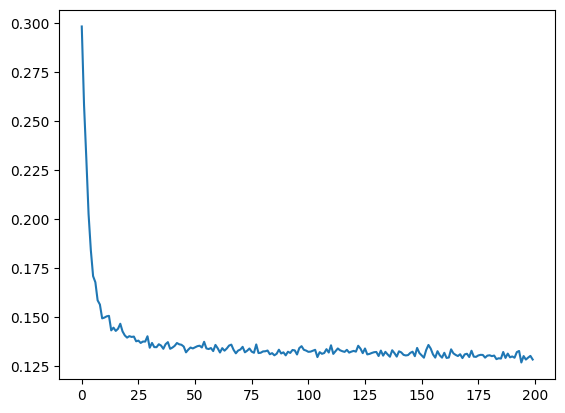

In [30]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [17]:
torch.save(up_changer.state_dict(), 'submission_files/moritz_deep3/new_scheduler_1_0.5_0.002.pth')

In [18]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


In [19]:
torch.save(test_predictions, 'submission_files/moritz_deep3/new_scheduler_1_0.5_0.002.pt')

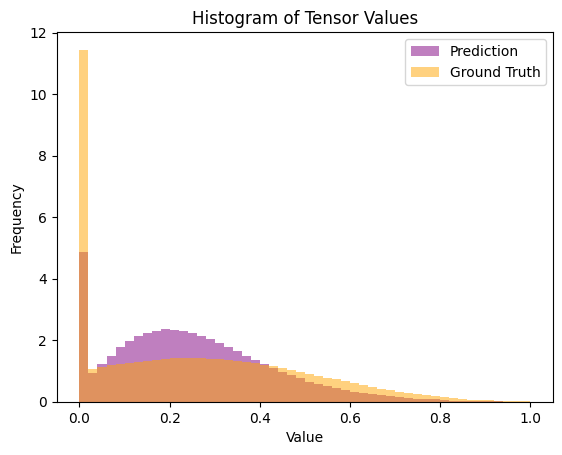

In [20]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

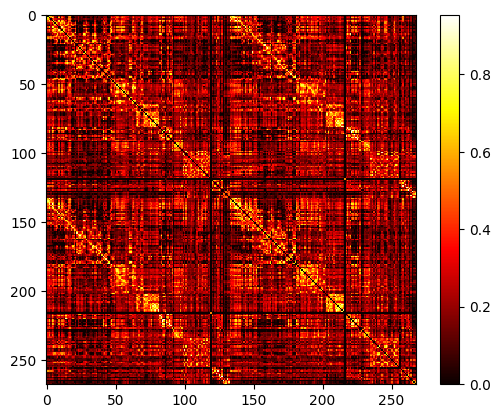

In [21]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [22]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/moritz_deep3/new_scheduler_1_0.5_0.002.csv')

# Cross Validation

In [12]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False, statement=None):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        if statement:
            print(statement)
        else:
            print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        if statement:
            print(statement)
        else:
            print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return {'eval': evaluate_predictions(val_predictions, val_adj_hr), 'preds': val_predictions}

In [13]:
def cross_validate(epochs, early, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=num_steps)
        channels_ls = channels_ls

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))
        
        losses = None
        completed = 0
        remaining = epochs
        val_metrics = {}
        if early>0 and early<epochs:
            up_changer, down_changer, losses = train(epochs-early, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer)

            testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
            val_metrics[f'{epochs-early}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap, statement=f'Currrent Fold after {epochs-early}')
            completed = epochs-early
            remaining = early

        up_changer, down_changer, losses = train(remaining, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=completed, loss_log=losses)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics[f'{epochs}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        val_metrics['losses'] = losses


        runs_results.append(val_metrics)

    return runs_results

ep 0: down loss = 0.2023075031382697, up loss = 0.17579166804041182, reconst.loss = 0.28973267333848135, down adj mae = 0.2714240976742336, up adj mae = 0.3006150083882468
ep 5: down loss = 0.12169325245278222, up loss = 0.09376371226140431, reconst.loss = 0.1975656236921038, down adj mae = 0.20502762070723943, up adj mae = 0.20174838602542877
ep 10: down loss = 0.0799880740897996, up loss = 0.061047208096299856, reconst.loss = 0.16775178909301758, down adj mae = 0.1881081461906433, up adj mae = 0.17220096715859004
ep 15: down loss = 0.06701621093920299, up loss = 0.052390417882374356, reconst.loss = 0.1560518592596054, down adj mae = 0.1744906519140516, up adj mae = 0.15751264137881144
ep 20: down loss = 0.047292927013976235, up loss = 0.03957605628030641, reconst.loss = 0.14481340135846818, down adj mae = 0.1663598609822137, up adj mae = 0.14864839613437653
ep 25: down loss = 0.04999914392828941, up loss = 0.043056704103946686, reconst.loss = 0.1455048152378627, down adj mae = 0.1545

100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Currrent Fold after 150


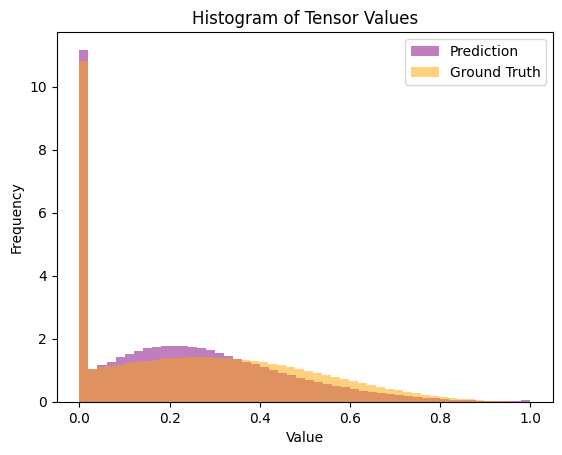

Currrent Fold after 150


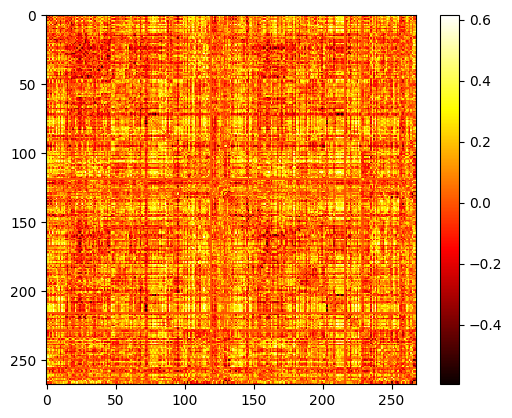

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [13:57<00:00, 14.96s/it]


MAE:  0.15826553
PCC:  0.5385711158804507
Jensen-Shannon Distance:  0.33432513694107147
Average MAE betweenness centrality: 0.020780570319692517
Average MAE eigenvector centrality: 0.01694020566227385
Average MAE PageRank centrality: 0.0008157525710354478
ep 0: down loss = 0.007773980498313904, up loss = 0.017155829817056656, reconst.loss = 0.13313886310373033, down adj mae = 0.13025502966982977, up adj mae = 0.131437110049384
ep 5: down loss = 0.006429859836186681, up loss = 0.01716958518539156, reconst.loss = 0.13074704791818345, down adj mae = 0.13377787598541804, up adj mae = 0.13106605410575867
ep 10: down loss = 0.0057671112673623225, up loss = 0.018219337133424624, reconst.loss = 0.1305987196309226, down adj mae = 0.13287452714783804, up adj mae = 0.13033950009516307
ep 15: down loss = 0.005441645492932626, up loss = 0.019558907885636603, reconst.loss = 0.13161654025316238, down adj mae = 0.13113362448556082, up adj mae = 0.1306549608707428
ep 20: down loss = 0.00563844253442117

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Histogram for Current Fold


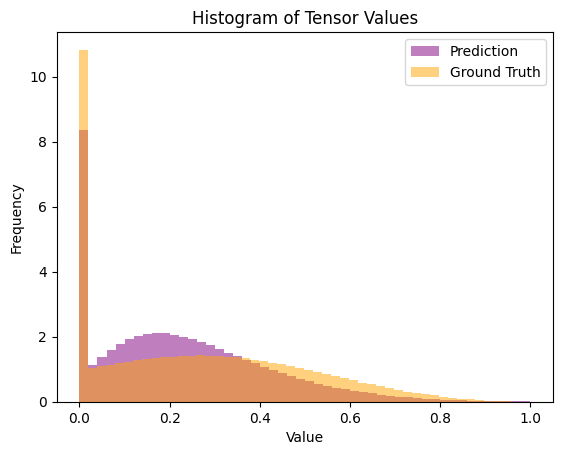

First Difference Heatmap for Current Fold


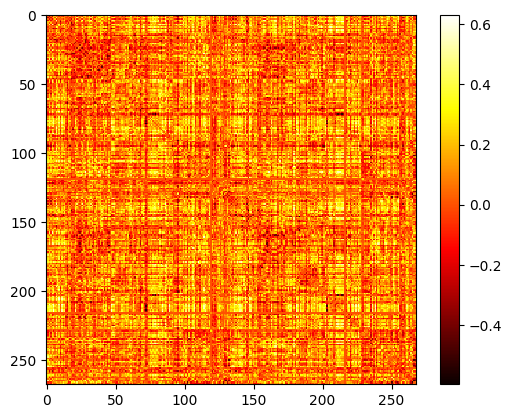

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [14:33<00:00, 15.59s/it]


MAE:  0.15171571
PCC:  0.5644647273306423
Jensen-Shannon Distance:  0.31433592561077306
Average MAE betweenness centrality: 0.020447919408016695
Average MAE eigenvector centrality: 0.015177641845790521
Average MAE PageRank centrality: 0.0006587652520442686
ep 0: down loss = 0.2052646598645619, up loss = 0.1813394171851022, reconst.loss = 0.3014031563486372, down adj mae = 0.2876216769218445, up adj mae = 0.31102808458464487
ep 5: down loss = 0.11998445327792849, up loss = 0.09220967654670988, reconst.loss = 0.19830179853098734, down adj mae = 0.22466613352298737, up adj mae = 0.20334561169147491
ep 10: down loss = 0.0810053784932409, up loss = 0.06327578212533679, reconst.loss = 0.1705698541232518, down adj mae = 0.19139537002359117, up adj mae = 0.1693242426429476
ep 15: down loss = 0.05655777667249952, up loss = 0.048649684126888006, reconst.loss = 0.15827253460884094, down adj mae = 0.17348568780081614, up adj mae = 0.15742285123893193
ep 20: down loss = 0.055208156151430945, up los

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Currrent Fold after 150


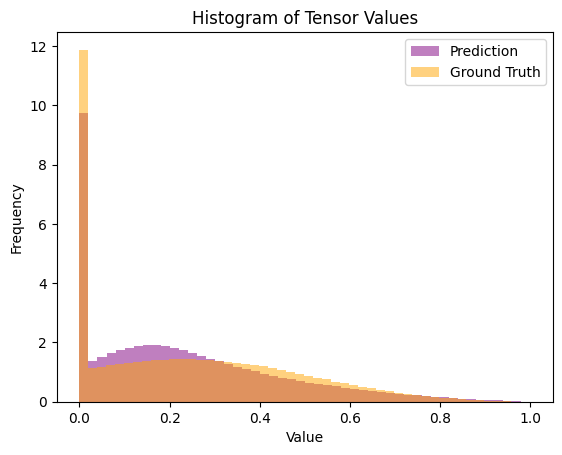

Currrent Fold after 150


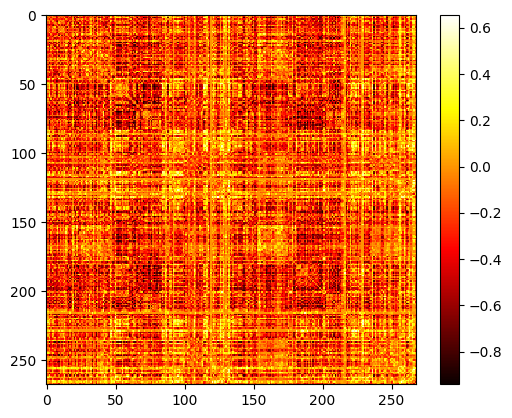

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [14:08<00:00, 15.16s/it]


MAE:  0.16914582
PCC:  0.45626565335910885
Jensen-Shannon Distance:  0.3554180654086055
Average MAE betweenness centrality: 0.02061519054518018
Average MAE eigenvector centrality: 0.015628205555947922
Average MAE PageRank centrality: 0.0007142312620940078
ep 0: down loss = 0.0074788979919893405, up loss = 0.016455125994980335, reconst.loss = 0.13122726125376566, down adj mae = 0.1405831894704274, up adj mae = 0.1300209675516401
ep 5: down loss = 0.0064453732089272565, up loss = 0.01714764695082392, reconst.loss = 0.1306949481368065, down adj mae = 0.13918845568384444, up adj mae = 0.13197665874447143
ep 10: down loss = 0.005747990350105933, up loss = 0.018186053527253016, reconst.loss = 0.13102271727153234, down adj mae = 0.1422001932348524, up adj mae = 0.13062559919697897
ep 15: down loss = 0.005776433872857264, up loss = 0.019287961136017526, reconst.loss = 0.13081195205450058, down adj mae = 0.14351228731019156, up adj mae = 0.13059266656637192
ep 20: down loss = 0.0054153671621211

100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Histogram for Current Fold


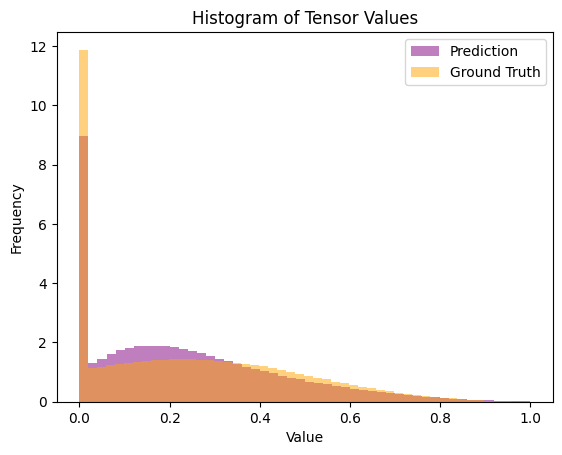

First Difference Heatmap for Current Fold


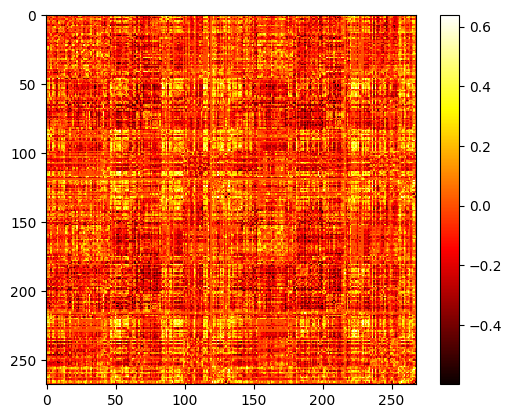

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [14:12<00:00, 15.23s/it]


MAE:  0.1607278
PCC:  0.5030112900814405
Jensen-Shannon Distance:  0.340713790380227
Average MAE betweenness centrality: 0.020883807197733677
Average MAE eigenvector centrality: 0.015401078566878893
Average MAE PageRank centrality: 0.0006955454449845262
ep 0: down loss = 0.20305595014776504, up loss = 0.1758680088179452, reconst.loss = 0.2917576049055372, down adj mae = 0.2649823746510914, up adj mae = 0.3031153210571834
ep 5: down loss = 0.12708520463534764, up loss = 0.09394952761275428, reconst.loss = 0.19712158611842565, down adj mae = 0.20591639833790915, up adj mae = 0.20013976522854396
ep 10: down loss = 0.08729457642350878, up loss = 0.06445082915680748, reconst.loss = 0.16227851382323674, down adj mae = 0.17706402497632162, up adj mae = 0.1590763564620699
ep 15: down loss = 0.06613816959517342, up loss = 0.04892440938523838, reconst.loss = 0.14870939723082952, down adj mae = 0.16282300225325994, up adj mae = 0.1456798357622964
ep 20: down loss = 0.04882254557950156, up loss = 

100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Currrent Fold after 150


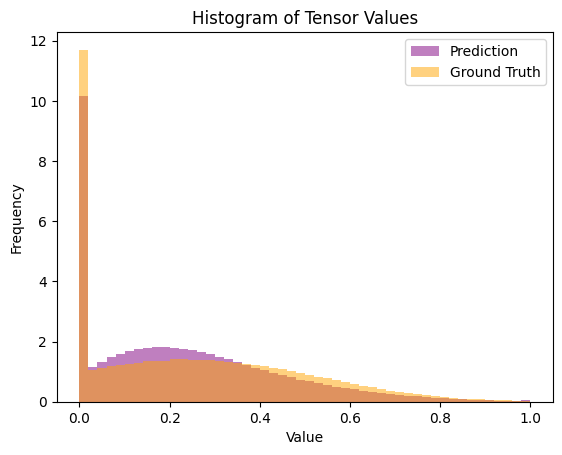

Currrent Fold after 150


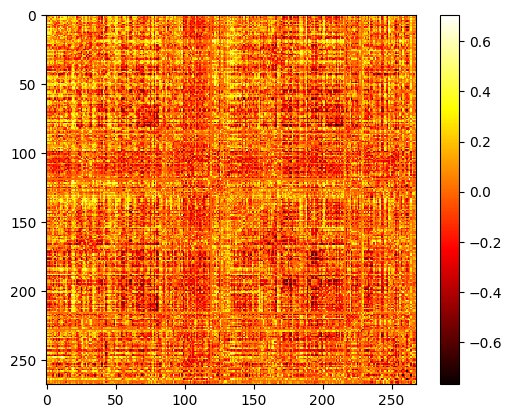

Evaluating Predictions (Can be Slow): 100%|██████████| 55/55 [13:51<00:00, 15.12s/it]


MAE:  0.17306192
PCC:  0.4498676715607068
Jensen-Shannon Distance:  0.3619720083210415
Average MAE betweenness centrality: 0.020612230651331432
Average MAE eigenvector centrality: 0.016092564521905647
Average MAE PageRank centrality: 0.0007181176625351546
ep 0: down loss = 0.007004458257662398, up loss = 0.015763599292508194, reconst.loss = 0.12842378552470887, down adj mae = 0.13030758925846644, up adj mae = 0.12702980424676621
ep 5: down loss = 0.006425913356776748, up loss = 0.01682876649179629, reconst.loss = 0.12868734023400716, down adj mae = 0.13117556273937225, up adj mae = 0.12941350787878036
ep 10: down loss = 0.005613218394241163, up loss = 0.017461114962186133, reconst.loss = 0.1280749174101012, down adj mae = 0.1316891312599182, up adj mae = 0.1279216068131583
ep 15: down loss = 0.005570579852376666, up loss = 0.01826212289077895, reconst.loss = 0.12831330405814306, down adj mae = 0.13243318455559866, up adj mae = 0.1296742366892951
ep 20: down loss = 0.005051818343677691,

100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Histogram for Current Fold


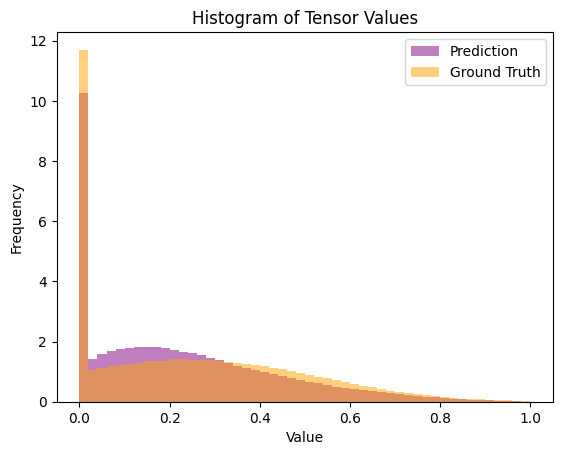

First Difference Heatmap for Current Fold


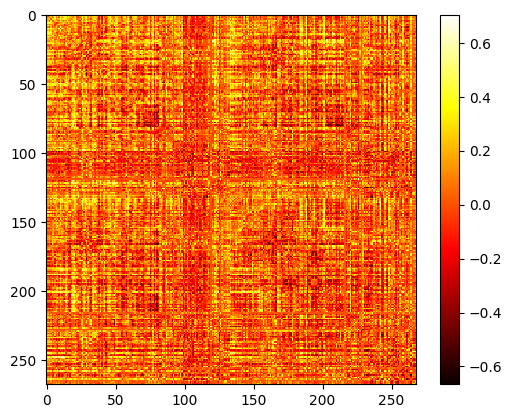

Evaluating Predictions (Can be Slow): 100%|██████████| 55/55 [14:05<00:00, 15.37s/it]

MAE:  0.17074442
PCC:  0.46876775971739054
Jensen-Shannon Distance:  0.3553569743723583
Average MAE betweenness centrality: 0.020883469249710192
Average MAE eigenvector centrality: 0.01544300062098811
Average MAE PageRank centrality: 0.0006735113587724707


In [14]:
import gc

#a=1

# del up_changer
# del down_changer
# del test_predictions
gc.collect()

torch.cuda.empty_cache()

results = cross_validate(200,50,16, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=12, histogram=True, heatmap=True)



In [22]:
torch.save(results, 'submission_files/moritz_deep3/results_cv_1_0.5_0.002.pt')

losses fold 0


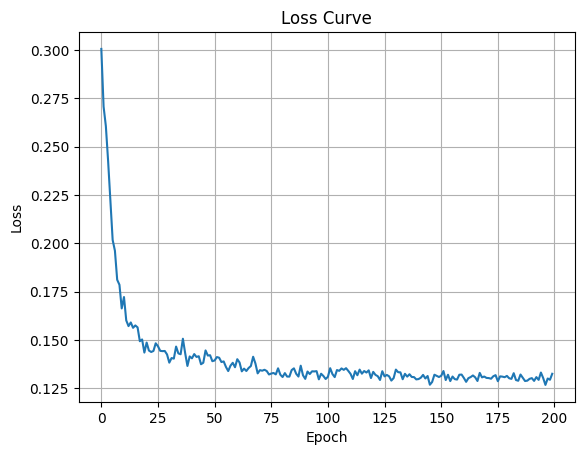

losses fold 1


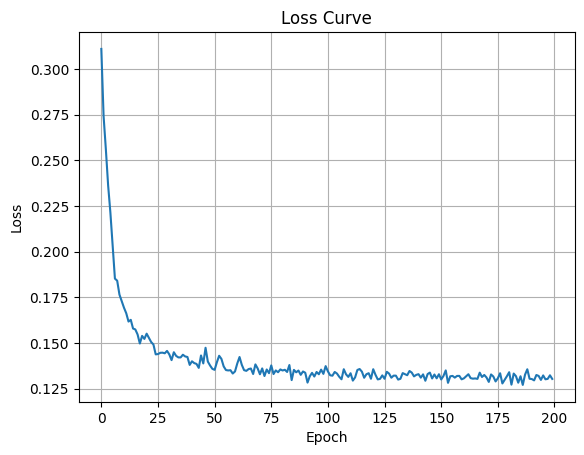

losses fold 2


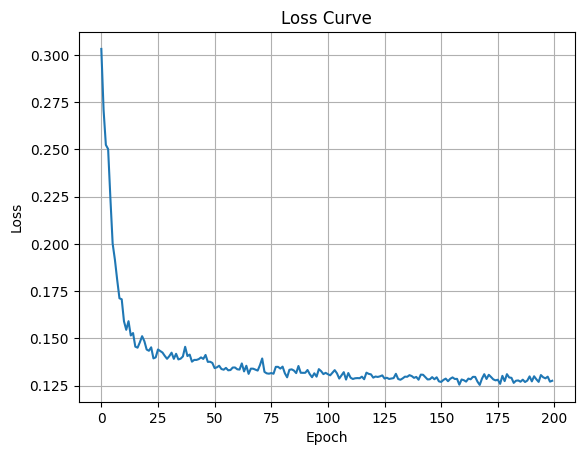

In [21]:
import matplotlib.pyplot as plt

for i in [0,1,2]:
    print(f'losses fold {i}')
    losses_fold = results[i]['losses']['up_end_mae']


    plt.plot(losses_fold)
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()